In [1]:
#track test
import sys, os
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))
from notebook_log_loading import load_sensor_log_file
from MessageToJSON import json_to_message
from id_to_name import id_to_name

#sensor_log,first_timestamp=load_sensor_log_file("../to_study/sound_study.txt")

In [2]:
import numpy as np
import torch
import torchaudio



melspectogram_transform = torchaudio.transforms.MelSpectrogram(
  sample_rate=16000, n_mels=64)
melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()

C:\Users\grybk\AppData\Roaming\Python\Python38\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\grybk\AppData\Roaming\Python\Python38\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


2
files are: ['sound_save_20210820-220420.wav', 'sound_save_20210820-220424.wav', 'sound_save_20210820-220427.wav']
fromat 8 
rate 16000 
fromat 8 
rate 16000 
fromat 8 
rate 16000 


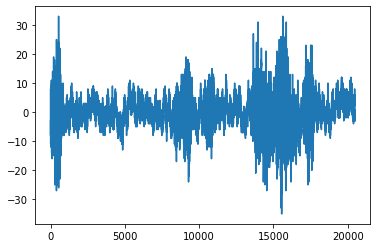

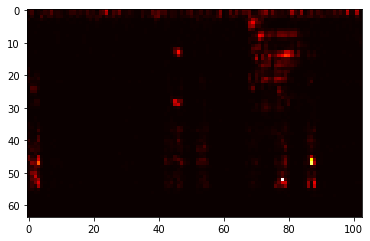

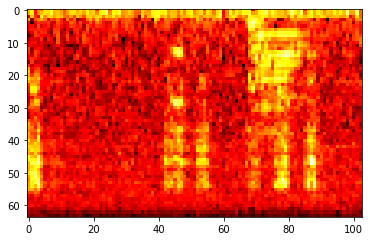

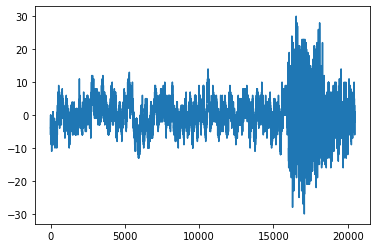

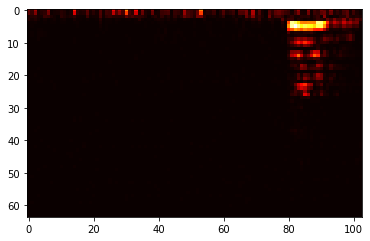

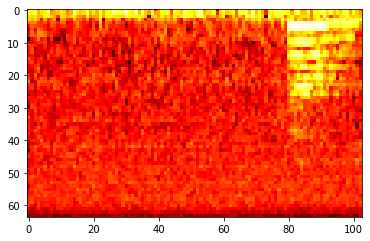

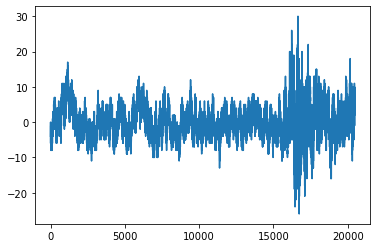

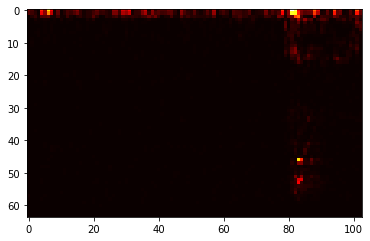

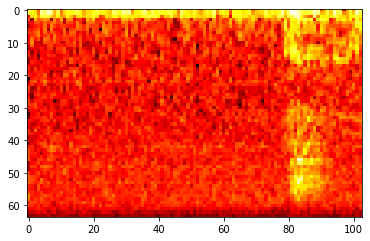

In [5]:
import matplotlib.pyplot as plt
import pyaudio
from os import walk
import wave
import array

p = pyaudio.PyAudio()
print(p.get_sample_size(pyaudio.paInt16))

mypath="../sounds/"
filenames = next(walk(mypath), (None, None, []))[2]
print("files are: {}".format(filenames))
max_chunk_size=16000*5 # 5 seconds

for f in filenames:
    wf = wave.open(mypath+f, 'rb')
    data = wf.readframes(max_chunk_size)
    wf.close()
    print("fromat {} ".format(p.get_format_from_width(wf.getsampwidth())))
    print("rate {} ".format(wf.getframerate()))
    stream = p.open(format = p.get_format_from_width(wf.getsampwidth()),
                channels = wf.getnchannels(),
                rate = wf.getframerate(),
                output = True)
    stream.write(data)
    stream.close()
    data = array.array('h', data)
    #turn into pytorch array
    data=torch.tensor(data).float()
    plt.figure()
    plt.plot(data[:])
    #turn into mel spectrograms
    melspectrogram=melspectogram_transform(data)
    plt.figure()
    plt.imshow(melspectrogram.squeeze().numpy(), cmap='hot')
 
    melspectogram_db=melspectogram_db_transform(melspectrogram)
    plt.figure()
    plt.imshow(melspectogram_db.squeeze().numpy(), cmap='hot')




In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 
    
class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
    
class CommandRecognizer(nn.Module):
    def __init__(self):
        super(CommandRecognizer,self).__init__()
        n_cnn_layers=3
        dropout=False
        n_feats=64
        self.cnn = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)